# Purpose of this notebook

This notebook accompanies the paper uploaded on Biorxiv, which is currently in revision for publication. The decoding analyses described in the paper can be found below. 

Once the data has been preprocessed and verified to your satisfaction, this is the notebook where the decoding analyses are run. The actual work of the decoding is once again specified in the `omission` module, specifically in `omission.build_classifier()`. For the purposes of the paper these analyses here are done on high-frequency band (70-150Hz) analytic amplitudes, but this notebook can be used with data involving different preprocessing steps as well. 

In this notebook there are a number of different decoding approaches: 
- Verification of heard-syllable decoding (sanity check): Can we decode hear 'Ba' from 'Ga sounds? 

- First pass omission decoding: feature selection based on above analysis (good heard-syllable decoding electrodes), followed by decoding of omitted Ba vs Ga

- Alternative decoding approach: Can we train the classifier on heard Ba/Ga, and use that to decode which syllable was omitted? (this is testing the strong hypothesis on template activation)

- Post-hoc analysis: Decoding of omitted syllable based on above-baseline omission activations

## Notebook setup and file loading

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2|

In [3]:
import os, glob, sys
import numpy as np
import pandas as pd
import mne
import omission
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
#import stats

from matplotlib.backends.backend_pdf import PdfPages

In [10]:
## Setup specifics per subject
foldername = {'AB62':'Albany62', 'AB71': 'Albany71', 'AB78':'Albany78', 'AB79': 'Albany79', 'AB81': 'Albany81'}
PicName = {}
elecNum = {251, 231}


In [11]:
# Select which subject you want to look at: 
subject_ID = 'AB62'
# 0- AB62, 1-AB71, 2-AB78, 3-AB79, 4-AB81'

In [13]:
foldername[subject_ID]

'Albany62'

## Load the data

In [14]:
epochs_fns = sorted(glob.glob('/home/knight/ECOGprediction/OmissionDetection/Data/' + foldername[subject_ID]+ '/sge/epochDataHilbertHG_Dig-B*'))
print epochs_fns

['/home/knight/ECOGprediction/OmissionDetection/Data/Albany62/sge/epochDataHilbertHG_Dig-B03.npz', '/home/knight/ECOGprediction/OmissionDetection/Data/Albany62/sge/epochDataHilbertHG_Dig-B04.npz', '/home/knight/ECOGprediction/OmissionDetection/Data/Albany62/sge/epochDataHilbertHG_Dig-B05.npz', '/home/knight/ECOGprediction/OmissionDetection/Data/Albany62/sge/epochDataHilbertHG_Dig-B06.npz', '/home/knight/ECOGprediction/OmissionDetection/Data/Albany62/sge/epochDataHilbertHG_Dig-B07.npz', '/home/knight/ECOGprediction/OmissionDetection/Data/Albany62/sge/epochDataHilbertHG_Dig-B08.npz']


In [15]:
ep_arrs = []
drop_chans = []
for f in epochs_fns:
    ep = np.load(f)
    globals().update(ep) # load all vars, changed 'locals' to 'globals' to fix error that came up when I turned this into a function
    print data.shape, info.item(), events.shape, tmin, event_id
    eparr = mne.EpochsArray(data, info.item(), events, tmin.item(), event_id.item(), baseline=None)
    #ep_arrs.append(eparr)
    if 'tmp' in locals():
        a = set(tmp).symmetric_difference( eparr.info['ch_names'])
        print 'following channel does not exist in all blocks'
        print a
        drop_chans.append(list(a))

    tmp = eparr.info['ch_names']


    ep_arrs.append(eparr)

#remove channels that are not in all blocks
print drop_chans
import itertools
flat_drop = list(itertools.chain.from_iterable(drop_chans))
good_chs = [ch for ch in ep_arrs[0].info['ch_names'] if ch not in
        flat_drop]


print('hello')

for i in range(len(ep_arrs)):
    ep_arrs[i].pick_channels(good_chs) #


event_ids = event_id.item()
all_epochs = mne.epochs.concatenate_epochs(ep_arrs)
print event_ids
del ep_arrs
del tmp

# If control block
#ep_arrs_control = []
#ep = np.load(epochs_fns_ctrl)
#locals().update(ep)
#print data.shape, info.item(), events.shape, t_min, event_id
#control_epochs = mne.EpochsArray(data, info.item(), events, t_min.item(), event_id.item(), baseline = None)

#event_idsControl = event_id.item()

(470, 229, 301) <Info | 16 non-empty fields
    bads : list | 0 items
    buffer_size_sec : float | 1.0
    ch_names : list | EEG 1, EEG 2, EEG 3, EEG 4, EEG 5, EEG 6, EEG 11, ...
    chs : list | 229 items (MISC: 229)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : 'mne.transforms.Transform | 3 items
    events : list | 0 items
    highpass : float | 70.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 25.0 Hz
    meas_date : numpy.ndarray | 1969-12-31 16:00:00
    nchan : int | 229
    projs : list | 0 items
    sfreq : float | 100.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
   

## Define options that will be used throughout the notebook for classification

In [16]:
n_cv = 10 # cross-validation iterations
n_ch = len(all_epochs.ch_names)
chan_scores = np.zeros(shape=(n_ch, n_cv)) # output structure for cv

In [17]:
t0 = 0 # seconds before (negative) or after stim to start classifying from
t1 = .5 # s after stim to stop using data to classify
percentiles = [.5, 2.5, 5, 50, 95, 97.5, 99.5]

In [ ]:
# finds relevant percentiles from bootstrap distr, based on values given in 'percentiles'
def pcts(scores, percentiles):
    for p in percentiles:
        print '%.1f%%: %.04f'%(p, np.percentile(scores, p))

In [ ]:
from sklearn import svm
logit = svm.LinearSVC(penalty= 'l2')
model = logit # model is the var that we pass to functions

## Code to setup plotting of data on de 2D brain

In [18]:
# Update accordingl
from os import path as op
from scipy.ndimage import imread

sub_name = 'AB62'
im_path = '/home/knight/ECOGprediction/Scripts/Python/Old/AB62gray.png'
print im_path
# We've already clicked and exported
layout_path = '/home/knight/ECOGprediction/Scripts/Python/Old'
layout_name = 'custom_layoutAB62.lout'

/home/knight/ECOGprediction/Scripts/Python/Old/AB62gray.png


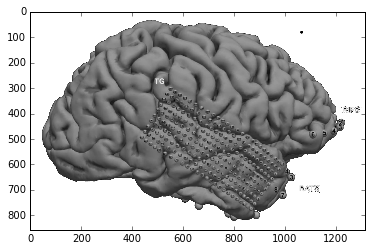

In [19]:
# Show the picture to check if it's the right one
im = imread(im_path)
plt.imshow(im)

In [21]:
# We've already got the layout, load it
lt = mne.channels.read_layout(layout_name, path=layout_path, scale=False)